# Import Package & Dataset

In [5]:
import pandas as pd
import re
import nltk
from nltk import download
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from collections import Counter, OrderedDict
from matplotlib import pyplot as plt
import tqdm
from sklearn.model_selection import train_test_split as tts
nltk.download('wordnet')
download("stopwords")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train = pd.read_csv('/content/drive/MyDrive/math4995_project2/train.csv')
test = pd.read_csv('/content/drive/MyDrive/math4995_project2/test.csv')

In [8]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

# Data Exploration and Visualization

In [ ]:
train.head() #7613

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test.head() #3263

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
train['text'].head(10)

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

In [ ]:
kw_counter = Counter(train['keyword'])
lct_counter = Counter(train['location'])

kw_dict= OrderedDict(kw_counter.most_common(11))
lct_dict= OrderedDict(lct_counter.most_common(11))

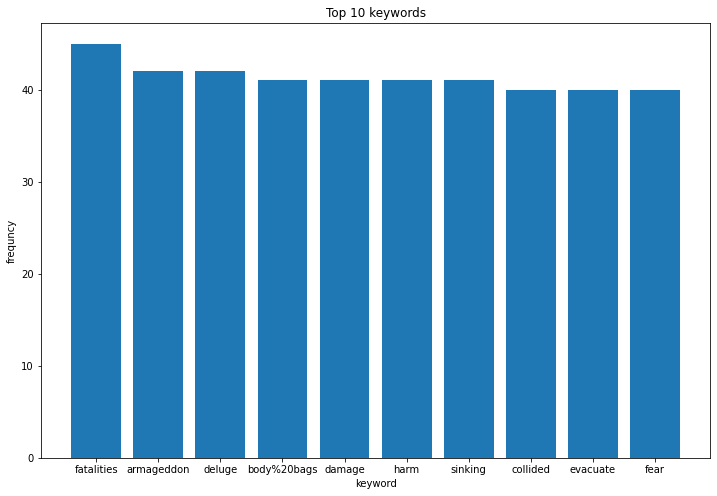

In [ ]:
fig = plt.figure(figsize = (12,8))
x1=list(kw_dict.keys())
y1 = list(kw_dict.values())

del x1[0]
del y1[0]
plt.bar(x1,y1)
plt.xlabel('keyword')
plt.ylabel('frequncy')
plt.title('Top 10 keywords')
plt.show()

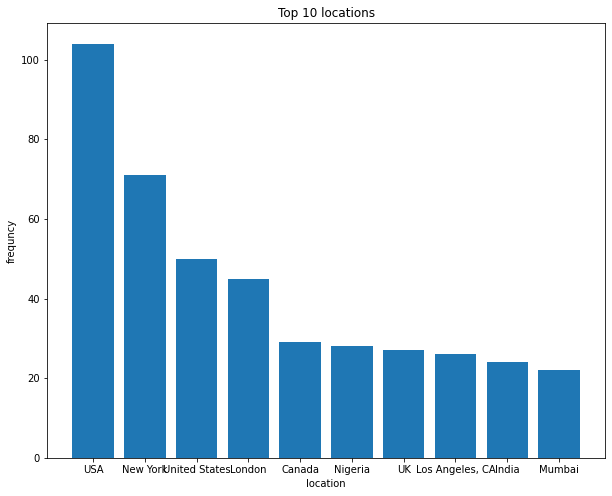

In [ ]:
fig = plt.figure(figsize = (10,8))
x2=list(lct_dict.keys())
y2 = list(lct_dict.values())

del x2[0]
del y2[0]
plt.bar(x2,y2)
plt.xlabel('location')
plt.ylabel('frequncy')
plt.title('Top 10 locations')
plt.show()

# Data Preprocessing

In [ ]:
X_train = pd.DataFrame({"tweet": train["text"]})
X_pred = pd.DataFrame({"tweet": test["text"]})
y_train = train["target"]

In [ ]:
def remove_URL(tweet):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', tweet)

def remove_special_chars(tweet):
    """ Function to remove special characters from tweets """
    tweet = re.sub("[0-9@,'\.#\)\(\*\?!\$\^\-\_\+\=~]+", "", tweet)
    return tweet

def word_tokenizer(tweet):
    """ NLTK word Tokenizer """
    regex_tokenizer = RegexpTokenizer(r"\w{3,}")
    return regex_tokenizer.tokenize(tweet)

def lemmatize_tweets(tweet):
    """ Lemmatize words """
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(tweet)

def remove_stopwords(tweet):
    """ Stop words removal function """
    stopwords_list = stopwords.words("english")
    for word in tweet:
        if word in stopwords_list:
            tweet.remove(word)
    return tweet

In [ ]:
X_train['tweet'] = X_train['tweet'].apply(lambda tweet: remove_URL(tweet))
X_train["tweet"] = X_train["tweet"].apply(lambda tweet: word_tokenizer(lemmatize_tweets(remove_special_chars(tweet.lower()))))
X_pred['tweet'] = X_pred['tweet'].apply(lambda tweet: remove_URL(tweet))
X_pred["tweet"] = X_pred["tweet"].apply(lambda tweet: word_tokenizer(lemmatize_tweets(remove_special_chars(tweet.lower()))))

X_train.head()

,tweet
0,"[our, deeds, are, the, reason, this, earthquak..."
1,"[forest, fire, near, ronge, sask, canada]"
2,"[all, residents, asked, shelter, place, are, b..."
3,"[people, receive, wildfires, evacuation, order..."
4,"[just, got, sent, this, photo, from, ruby, ala..."


In [ ]:
X_train["tweet"] = X_train["tweet"].apply(lambda tweet: " ".join(remove_stopwords(tweet)))
X_train["tweet"].head()

X_pred["tweet"] = X_pred["tweet"].apply(lambda tweet: " ".join(remove_stopwords(tweet)))
#X_pred["tweet"].head()

In [ ]:
X_train['tweet'][40]

'check out nsfw'

CountVectorizer

In [ ]:
cv = CountVectorizer()
matrix = cv.fit_transform(X_train["tweet"])
counts = pd.DataFrame(matrix.toarray(),
                  columns=cv.get_feature_names())

f = cv.get_feature_names()
print(len(f))

16459


In [ ]:
counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Columns: 16459 entries, aaaa to ûówe
dtypes: int64(16459)
memory usage: 956.0 MB


In [ ]:
def mark_text(text):
    return "[CLS] " + text + " [SEP]"
X_train["tweet"] = X_train["tweet"].apply(mark_text)
X_pred["tweet"] = X_pred["tweet"].apply(mark_text)

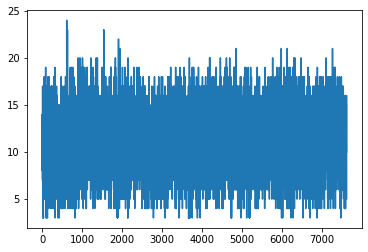

In [ ]:
import matplotlib.pyplot as plt
len_list = [len(words.split()) for words in X_train.tweet]

plt.plot(len_list)
plt.show()

In [ ]:
X_pred["tweet"]

0                 [CLS] happened terrible car crash [SEP]
1       [CLS] heard earthquake different cities stay s...
2       [CLS] forest fire spot pond geese fleeing acro...
3       [CLS] apocalypse lighting spokane wildfires [SEP]
4         [CLS] typhoon soudelor kills china taiwan [SEP]
                              ...                        
3258    [CLS] earthquake safety los angeles safety fas...
3259    [CLS] storm worse last hurricane city amp othe...
3260            [CLS] green line derailment chicago [SEP]
3261    [CLS] meg issues hazardous weather outlook hwo...
3262    [CLS] cityofcalgary activated municipal emerge...
Name: tweet, Length: 3263, dtype: object

# Fine Tuned BERT

In [ ]:
N_TRAIN = 0.9
df = pd.DataFrame({'Label':y_train,'Text':X_train.tweet})
df_train, df_val = tts(df, train_size = N_TRAIN, shuffle = True, random_state = 42)

In [ ]:
!pip3 install transformers
from transformers import RobertaTokenizer
# Load the BERT tokenizer.
print('Loading Roberta tokenizer...')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

     |████████████████████████████████| 3.1 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 50.0 MB/s 
     |████████████████████████████████| 596 kB 42.3 MB/s 
     |████████████████████████████████| 3.3 MB 35.1 MB/s 
     |████████████████████████████████| 59 kB 7.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Loading Roberta tokenizer...


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
train_input_ids = []
# For every sentence...
for sent in df_train["Text"]:

    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        
                   )
    
    # Add the encoded sentence to the list.
    train_input_ids.append(encoded_sent)


In [ ]:
print('Max sentence length: ', max([len(sen) for sen in train_input_ids]))

Max sentence length:  48


In [ ]:
from keras.preprocessing.sequence import pad_sequences
# Set the maximum sequence length.

MAX_LEN = 256
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))
# Pad our input tokens with value 0.

train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
print('\Done.')


Padding/truncating all sentences to 256 values...

Padding token: "<pad>", ID: 1
\Done.


In [ ]:
# Create attention masks
train_attention_masks = []
# For each sentence...
for sent in train_input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    train_attention_masks.append(att_mask)

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
valid_input_ids = []
for sent in df_val['Text']:

    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        
                   )
    
    # Add the encoded sentence to the list.
    valid_input_ids.append(encoded_sent)

print('Max sentence length: ', max([len(sen) for sen in valid_input_ids]))


from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 256
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))
# Pad our input tokens with value 0.

valid_input_ids = pad_sequences(valid_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
print('\Done.')

# Create attention masks
valid_attention_masks = []
# For each sentence...
for sent in valid_input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    valid_attention_masks.append(att_mask)


Max sentence length:  43

Padding/truncating all sentences to 256 values...

Padding token: "<pad>", ID: 1
\Done.


In [ ]:
train_inputs, valid_inputs = train_input_ids, valid_input_ids
train_masks, valid_masks = train_attention_masks, valid_attention_masks
train_labels, valid_labels = df_train['Label'], df_val['Label']
train_labels = list(train_labels)
valid_labels = list(valid_labels)

In [ ]:
import torch
import pandas as pd
import re

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(valid_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(valid_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(valid_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
from transformers import RobertaForSequenceClassification, AdamW, RobertaConfig
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 0.000015, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
from transformers import get_linear_schedule_with_warmup
# Number of training epochs (authors recommend between 2 and 4)
epochs = 3
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# use GPU if available
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('Use GPU')
else:
    device = torch.device("cpu")

Use GPU


In [ ]:
loss_values = []
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad()        
        
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]
        if step % 20 == 19:
          print(loss)
        
        total_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        
        with torch.no_grad():        
            
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        
        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
        
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
tensor(0.7840, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5655, device='cuda:0', grad_fn=<NllLossBackward>)
  Batch    40  of    215.    Elapsed: 0:01:47.
tensor(0.5338, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4341, device='cuda:0', grad_fn=<NllLossBackward>)
  Batch    80  of    215.    Elapsed: 0:03:33.
tensor(0.3818, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4381, device='cuda:0', grad_fn=<NllLossBackward>)
  Batch   120  of    215.    Elapsed: 0:05:19.
tensor(0.3860, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3040, device='cuda:0', grad_fn=<NllLossBackward>)
  Batch   160  of    215.    Elapsed: 0:07:05.
tensor(0.3176, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4994, device='cuda:0', grad_fn=<NllLossBackward>)
  Batch   200  of    215.    Elapsed: 0:08:51.

  Average training loss: 0.55
  Training epcoh took: 0:09:28

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:24

==

In [ ]:
X_pred["tweet"].head()

0              [CLS] happened terrible car crash [SEP]
1    [CLS] heard earthquake different cities stay s...
2    [CLS] forest fire spot pond geese fleeing acro...
3    [CLS] apocalypse lighting spokane wildfires [SEP]
4      [CLS] typhoon soudelor kills china taiwan [SEP]
Name: tweet, dtype: object

In [ ]:
# make predictions on test set
test_input_ids = []
for sent in X_pred["tweet"]:
    
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    test_input_ids.append(encoded_sent)
# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")
# Create attention masks
test_attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
  seq_mask = [float(i>0) for i in seq]
  test_attention_masks.append(seq_mask) 
# Convert to tensors.
prediction_inputs = torch.tensor(test_input_ids)
prediction_masks = torch.tensor(test_attention_masks)
prediction_labels = torch.tensor([0]*len(test_input_ids))
# Set the batch size.  
batch_size = 32  
# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask, b_labels = batch
  

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  # label_ids = b_labels.to('cpu').numpy()
  logits = np.argmax(logits, axis=1).flatten()
  # Store predictions and true labels
  predictions.append(logits+1)
  # true_labels.append(label_ids)
print('DONE.')

Predicting labels for 3,263 test sentences...
DONE.


In [ ]:
import plotly.express as px
f = pd.DataFrame(loss_values)
f.columns=['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Training loss of the Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

In [ ]:
ans = list(predictions[0])
for i in predictions[1:]:
  ans.extend(list(i))

for i in range(len(ans)):
  ans[i] -= 1

In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
(pd.DataFrame({'id':test.id, 'target':ans})).to_csv('test_sample.csv')

# Bi_LSTM with Multiheads Attention

## Setting, importing from Kaggle



In [1]:
!pip install kaggle
!mkdir .kaggle

In [2]:
import json
token = {"username":"math4995caisong","key":"a2a070c8e63ae3deb99ade67956f027f"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [3]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!kaggle config set -n path -v{/content}

#!kaggle datasets download -d kazanova/sentiment140 -p /content
!kaggle datasets download -d fullmetal26/glovetwitter27b100dtxt

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip \*.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


点开解压的文件夹到最里面有一个zip文件拖到外面

In [ ]:
!unzip \*.zip

Archive:  glovetwitter27b100dtxt.zip
  inflating: glove.twitter.27B.200d.txt  


## Bi-LSTM Modelling

In [ ]:
# Constants:

# Contains 1.6M samples
#PATH_DATA = "./input/training.1600000.processed.noemoticon.csv"

# GloVe Twitter embeddings: 2B tweets, 27B tokens, 1.2M vocab, uncased,200-dimensional
PATH_EMB =  '/content/glove.twitter.27B.200d.txt'
N_EMB = 200 # Dimensions of the embeddings

# Using fastText Word vectors trained on Wikipedia 2017, UMBC webbase corpus, and statmt.org
# PATH_EMB = "../input/fasttext-wikinews/wiki-news-300d-1M.vec"
# N_EMB = 300

# Number of samples to be taken
LIMIT = 1600000

# Fraction of samples to be used for training set
N_TRAIN = 0.9

# Size of each sequence to be embedded:
N_SEQ = 0 # Chosen later based on the histogram of the lengths#

In [ ]:
X_train["tweet"].head()

0    [CLS] deeds the reason earthquake may allah fo...
1       [CLS] forest fire near ronge sask canada [SEP]
2    [CLS] residents asked shelter place being noti...
3    [CLS] people receive wildfires evacuation orde...
4    [CLS] got sent photo ruby alaska smoke wildfir...
Name: tweet, dtype: object

In [ ]:
y_train.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [ ]:
df = pd.DataFrame({'Label':y_train,'Text':X_train.tweet})

## Analyze the length of the tweets:
This will help us select the N_SEQ

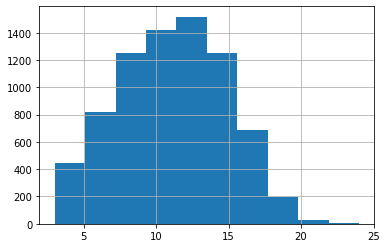

Mean: 11.2221
Std: 3.5573
Mean+3*Std = 21.8940


In [ ]:
lengths = X_train["tweet"].apply(lambda x : len(x.split(" "))) # try mean + 3*sigma
lengths.hist()
plt.show()

mean = lengths.mean()
std = lengths.std()
approx_nseq = mean + 3*std
print(f"Mean: {mean:.4f}\nStd: {std:.4f}\nMean+3*Std = {approx_nseq:.4f}")

In [ ]:
N_SEQ = 32


## Preparation before model training
Doing this in Keras is quite simple and intuitive

In [ ]:


# Split into training and validation sets
df_train, df_val = tts(df, train_size = N_TRAIN, shuffle = True, random_state = 42)

In [ ]:
from keras.preprocessing.text import Tokenizer

def getTokenizer():
    tok = Tokenizer()
    # Create word_index and vocab
    tok.fit_on_texts(df_train["Text"])
    return tok

In [ ]:
tok = getTokenizer()
word_index = tok.word_index
N_vocab = len(tok.word_index) + 1 # +1 for the 0 padding
print(N_vocab)

15410


In [ ]:
from keras.preprocessing.sequence import pad_sequences

def getXY(tok):
    x_train = pad_sequences(tok.texts_to_sequences(df_train["Text"]), maxlen = N_SEQ, padding = "post")
    x_val   = pad_sequences(tok.texts_to_sequences(df_val["Text"]), maxlen = N_SEQ, padding = "post")
    y_train = df_train["Label"].to_numpy(dtype = float).reshape(-1, 1)
    y_val   = df_val["Label"].to_numpy(dtype = float).reshape(-1, 1)
    return x_train, x_val, y_train, y_val

In [ ]:
x_train, x_val, y_train, y_val = getXY(tok) # All are nice numpy arrays

## Preparing the Embeddings

In [ ]:
import torch
# Maps each word in the embeddings vocabulary to it's embedded representation 

In [ ]:
embeddings_index = {}
with open(PATH_EMB, "r", errors="ignore") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# Maps each word in our vocab to it's embedded representation, if the word is present in the GloVe embeddings
embedding_matrix = np.zeros((N_vocab, N_EMB))
n_match = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        n_match += 1
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.normal(0, 1, (N_EMB,))
print("Vocabulary match: ", n_match)

# Convert to torch tensor to be used directly in the embedding layer:
embeddings_tensor = torch.FloatTensor(embedding_matrix).to(device)

Vocabulary match:  11646


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Data ready to be loaded:
data_train = TensorDataset(torch.from_numpy(x_train).long(), torch.from_numpy(y_train).long())
data_val = TensorDataset(torch.from_numpy(x_val).long(), torch.from_numpy(y_val).long())

In [ ]:
N_BATCH = 128

# Create dataloaders, we have already shuffled our data
loader_train = DataLoader(data_train, shuffle = False, batch_size = N_BATCH)
loader_val = DataLoader(data_val, shuffle = False, batch_size = N_BATCH)

## The model:

In [ ]:
N_EPOCHS = 20
OUTPUT_DIM = 1
HIDDEN_DIM = 64 # Output dimension of the LSTM
lr=0.0001

### Utility fuctions:

In [ ]:
def countParameters(model):
    """ Counts the total number of trainiable parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

In [ ]:
import torch.nn.functional as F

def binary_accuracy(logits, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # Round predictions to the closest integer
    preds = torch.sigmoid(logits)
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def train(model, iterator, optimizer, criterion):
    """ Trains the model on the given training set """
    epoch_loss = 0
    epoch_acc = 0
    
    model.train() # Tells your model that you are training the model
    
    for text, labels in iterator:
        
        # https://discuss.pytorch.org/t/how-to-add-to-attribute-to-dataset/86468
        text = text.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() # Zero the previous gradients
        
        logits = model(text)
        labels = labels.type_as(logits)
        
        loss = criterion(logits, labels)
        acc = binary_accuracy(logits, labels)
        
        loss.backward() # Compute gradients
        
        optimizer.step() # Make the updates
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    """ Evaluates the model on the validation set """
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval() # Tells the model that we are currently evaluating the model
    
    with torch.no_grad(): # Temporarily set all the requires_grad flag to false
    
        for text, labels in iterator:
            
            text = text.to(device)
            labels = labels.to(device)

            logits = model(text)
            labels = labels.type_as(logits)
            
            loss = criterion(logits, labels)
            acc = binary_accuracy(logits, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [ ]:
import torch.nn as nn

class Model(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout = 0.2):
        
        super().__init__()
        # Embedding
        self.embedding = nn.Embedding.from_pretrained(embeddings_tensor, freeze = True)
        # BiLSTM
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers = 1,
            bidirectional = True, 
            # dropout = dropout, # adds dropout on the connections between hidden states in one layer to hidden states in the next layer.
            batch_first = True
        )
        # Multihead attention:
        self.mha = nn.MultiheadAttention(2*hidden_dim, num_heads = 8)
        # Flatten into [batch_size, 2*N_HIDDEN*N_SEQ]
        self.flatten = nn.Flatten() 
        # Fully connected classifer
        self.fc1 = nn.Linear(N_SEQ*2*hidden_dim, 1024) # As bidirectional
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(1024, 256)
        self.dropout = nn.Dropout(dropout)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, output_dim)
        
    def forward(self, text):
        # Embedding of the given "text" represented as a vector
        embedded = self.embedding(text)  # [batch size, sent len, emb dim]
        # LSTM output
        lstm_output, (ht, cell) = self.lstm(embedded) # [batch size, sent len, hid dim], [ batch size, 1, hid dim]
        # Compute attention:
        attn_output, attn_output_weights = self.mha(lstm_output, lstm_output, lstm_output)
        # Flatten:
        x = self.flatten(attn_output)
        # Classifer:
        # Layer 1
        x = self.fc1(x)
        x = F.relu(x)
        # Dropout
        x = self.dropout(x)
        # Layer 2
        x = self.fc2(x)
        x = F.relu(x)
        # Layer 3
        x = self.fc3(x)
        x = F.relu(x)
        # Output layer
        output = self.fc4(x)
        
        return output # No need for sigmoid, our loss function will apply that for us

In [ ]:
model = Model(N_vocab, N_EMB, HIDDEN_DIM, OUTPUT_DIM)
trainable, frozen = countParameters(model)

print(model)
print(f"The model has {trainable:,} trainable parameters and {frozen:,} frozen parameters")

Model(
  (embedding): Embedding(15410, 200)
  (lstm): LSTM(200, 64, batch_first=True, bidirectional=True)
  (mha): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)
The model has 4,668,225 trainable parameters and 3,082,000 frozen parameters


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss() # Binary crossentropy: This computes sigma(logits) too, much more numerically stable

In [ ]:
# Place on GPU if available
model = model.to(device)
criterion = criterion.to(device)

### Training:

In [ ]:
# The actual training and validation:

best_valid_loss = float("inf")

history = {
    "t_loss" : [],
    "v_loss" : [],
    "t_acc" : [],
    "v_acc" : []
}

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, loader_train, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, loader_val, criterion)
    
    end_time = time.time()
    
    history["t_loss"].append(train_loss)
    history["v_loss"].append(valid_loss)
    history["t_acc"].append(train_acc)
    history["v_acc"].append(valid_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Saves best only
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f"model_{epoch+1}.pt")
    
    # Print details about each epoch:
    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")

Epoch: 01 | Epoch Time: 0m 17s
	Train Loss: 0.687 | Train Acc: 55.23%
	 Val. Loss: 0.686 |  Val. Acc: 55.94%
Epoch: 02 | Epoch Time: 0m 16s
	Train Loss: 0.683 | Train Acc: 57.20%
	 Val. Loss: 0.686 |  Val. Acc: 55.94%
Epoch: 03 | Epoch Time: 0m 16s
	Train Loss: 0.683 | Train Acc: 57.20%
	 Val. Loss: 0.686 |  Val. Acc: 55.94%
Epoch: 04 | Epoch Time: 0m 16s
	Train Loss: 0.683 | Train Acc: 57.20%
	 Val. Loss: 0.686 |  Val. Acc: 55.94%
Epoch: 05 | Epoch Time: 0m 16s
	Train Loss: 0.680 | Train Acc: 57.20%
	 Val. Loss: 0.672 |  Val. Acc: 55.94%
Epoch: 06 | Epoch Time: 0m 16s
	Train Loss: 0.570 | Train Acc: 71.03%
	 Val. Loss: 0.485 |  Val. Acc: 79.28%
Epoch: 07 | Epoch Time: 0m 16s
	Train Loss: 0.476 | Train Acc: 78.39%
	 Val. Loss: 0.465 |  Val. Acc: 79.40%
Epoch: 08 | Epoch Time: 0m 16s
	Train Loss: 0.452 | Train Acc: 79.75%
	 Val. Loss: 0.457 |  Val. Acc: 79.64%
Epoch: 09 | Epoch Time: 0m 16s
	Train Loss: 0.438 | Train Acc: 80.60%
	 Val. Loss: 0.452 |  Val. Acc: 80.18%
Epoch: 10 | Epoch T

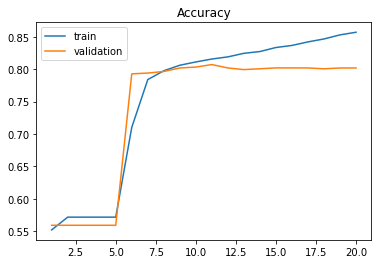

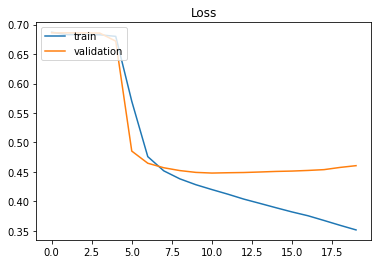

In [ ]:
# Plots

t_acc = history["t_acc"]
t_loss = history["t_loss"]
v_acc = history["v_acc"]
v_loss = history["v_loss"]

epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, t_acc)
plt.plot(epochs, v_acc)
plt.title("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')

plt.figure()
plt.plot(t_loss)
plt.plot(v_loss)
plt.title("Loss")
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

In [ ]:
# test with some tweets

test_tweet = pad_sequences(tok.texts_to_sequences(df_train["Text"][:3]), maxlen = N_SEQ, padding = "post")
test_tweet_label = df_train["Label"][:3].to_numpy(dtype = float).reshape(-1, 1)
test_tweet=torch.from_numpy(test_tweet).long().to(device)
test_tweet_pred=torch.round(torch.sigmoid(model(test_tweet))).cpu().detach().numpy()

for i in range(3):
    print(f' {df_train["Text"].iloc[i]} : predicted label {test_tweet_pred[i]}, true label {test_tweet_label[i]}')

 [CLS] mcfadden reportedly test hamstring thursday via teamstream [SEP] : predicted label [0.], true label [0.]
 [CLS] nema warns nigerians prepare drought [SEP] : predicted label [1.], true label [1.]
 [CLS] was cooking earlier got electrocuted crucial psychic lol [SEP] : predicted label [0.], true label [0.]


# Bi-LSTM

## The Model:

### Utility functions:

In [ ]:
def countParameters(model):
    """ Counts the total number of trainiable parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # Round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout = 0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings_tensor, freeze = True)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers = 2, 
            bidirectional = True, 
            dropout = dropout,
            batch_first = True
        )
        self.fc = nn.Linear(hidden_dim*2, output_dim) # As bidirectional
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        # text: [sentlen, batch size]
        
        embedded = self.embedding(text)  # [batch size, sent len, emb dim]
        
        # lstm_output: concatentation of all hidden states
        # hidden: The final hidden state h_T
        
        lstm_output, (hidden, cell) = self.lstm(embedded) # [batch size, sent len, hid dim], [ batch size, 1, hid dim] 
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        
        output = self.fc(hidden)
        
        return output # No need for sigmoid, our loss function will apply that for us

In [ ]:
model = LSTM(N_vocab, N_EMB, HIDDEN_DIM, OUTPUT_DIM)
trainable, frozen = countParameters(model)

print(model)
print(f"The model has {trainable:,} trainable parameters and {frozen:,} frozen parameters")

LSTM(
  (embedding): Embedding(15410, 200)
  (lstm): LSTM(200, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
The model has 235,649 trainable parameters and 3,082,000 frozen parameters


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss() # This computes sigma(logits) too

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer, criterion):
    """ Trains the model on the given training set """
    epoch_loss = 0
    epoch_acc = 0
    
    model.train() # Tells your model that you are training the model
    
    for text, label in iterator:
        text = text.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
                
        predictions = model(text)
        
        label = label.type_as(predictions)
        
        loss = criterion(predictions, label)
        
        acc = binary_accuracy(predictions, label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

### Training:

In [ ]:
def evaluate(model, iterator, criterion):
    """ Evaluates the model on the validation set """
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval() # Tells the model that we are currently evaluating the model
    
    with torch.no_grad(): # Temporarily set all the requires_grad flag to false
    
        for text, label in iterator:
            text = text.to(device)
            label = label.to(device)
            predictions = model(text)
            
            label = label.type_as(predictions)
            
            loss = criterion(predictions, label)
            
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [ ]:
# The actual training and validation:

best_valid_loss = float("inf")

history = {
    "t_loss" : [],
    "v_loss" : [],
    "t_acc" : [],
    "v_acc" : []
}

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, loader_train, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, loader_val, criterion)
    
    end_time = time.time()
    
    history["t_loss"].append(train_loss)
    history["v_loss"].append(valid_loss)
    history["t_acc"].append(train_acc)
    history["v_acc"].append(valid_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Saves best only
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    # Print details about each epoch:
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.685 | Train Acc: 55.84%
	 Val. Loss: 0.676 |  Val. Acc: 55.94%
Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.656 | Train Acc: 59.43%
	 Val. Loss: 0.623 |  Val. Acc: 68.70%
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.556 | Train Acc: 76.02%
	 Val. Loss: 0.498 |  Val. Acc: 77.71%
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.480 | Train Acc: 79.02%
	 Val. Loss: 0.478 |  Val. Acc: 77.83%
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.460 | Train Acc: 80.39%
	 Val. Loss: 0.469 |  Val. Acc: 78.08%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.449 | Train Acc: 80.84%
	 Val. Loss: 0.462 |  Val. Acc: 79.14%
Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 0.439 | Train Acc: 81.26%
	 Val. Loss: 0.459 |  Val. Acc: 79.27%
Epoch: 08 | Epoch Time: 0m 9s
	Train Loss: 0.430 | Train Acc: 81.66%
	 Val. Loss: 0.456 |  Val. Acc: 79.53%
Epoch: 09 | Epoch Time: 0m 9s
	Train Loss: 0.426 | Train Acc: 82.10%
	 Val. Loss: 0.453 |  Val. Acc: 79.92%
Epoch: 10 | Epoch Time: 0m 

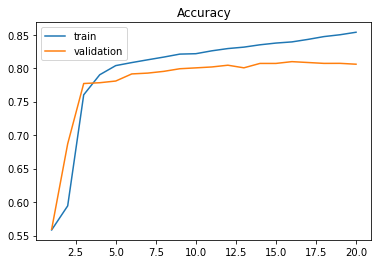

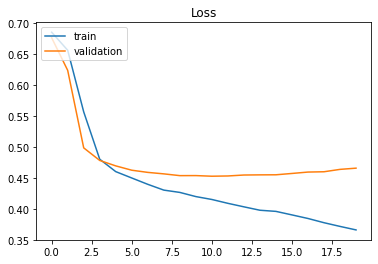

In [ ]:
t_acc = history["t_acc"]
t_loss = history["t_loss"]
v_acc = history["v_acc"]
v_loss = history["v_loss"]

epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, t_acc)
plt.plot(epochs, v_acc)
plt.title("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')

plt.figure()
plt.plot(t_loss)
plt.plot(v_loss)
plt.title("Loss")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:

# test with some tweets

test_tweet = pad_sequences(tok.texts_to_sequences(df_train["Text"][:3]), maxlen = N_SEQ, padding = "post")
test_tweet_label = df_train["Label"][:3].to_numpy(dtype = float).reshape(-1, 1)
test_tweet=torch.from_numpy(test_tweet).long().to(device)
test_tweet_pred=torch.round(torch.sigmoid(model(test_tweet))).cpu().detach().numpy()

for i in range(3):
    print(f' {df_train["Text"].iloc[i]} : predicted label {test_tweet_pred[i]}, true label {test_tweet_label[i]}')

 [CLS] mcfadden reportedly test hamstring thursday via teamstream [SEP] : predicted label [0.], true label [0.]
 [CLS] nema warns nigerians prepare drought [SEP] : predicted label [1.], true label [1.]
 [CLS] was cooking earlier got electrocuted crucial psychic lol [SEP] : predicted label [0.], true label [0.]


In [ ]:
(pd.DataFrame({'id':test.id, 'target':ans})).to_csv('test_sample.csv')

# BERT

In [ ]:
!pip install transformers
from transformers import BertTokenizer, BertModel
import tokenize
import string
import torch
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

X_tr, X_ts, y_tr, y_ts = train_test_split(X_train.tweet, y_train, test_size=0.2, random_state=4211)

print(len(y_tr))
print(type(y_tr))


     |████████████████████████████████| 3.1 MB 14.9 MB/s 
     |████████████████████████████████| 895 kB 48.3 MB/s 
     |████████████████████████████████| 3.3 MB 47.6 MB/s 
     |████████████████████████████████| 596 kB 55.2 MB/s 
     |████████████████████████████████| 59 kB 5.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
6090
<class 'pandas.core.series.Series'>


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenized_text = [tokenizer.tokenize(txt) for txt in text]
# print (tokenized_text[0:10])
print(len(y_train))

#transformed into list of vectors
encoded_data_train = tokenizer.batch_encode_plus(
    X_tr, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=24, 
    return_tensors='pt'
)#text[0:15000]

encoded_data_val = tokenizer.batch_encode_plus(
    X_ts, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=24, 
    return_tensors='pt'
)#text[15000:len(text)]

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_tr.to_numpy(dtype=int)) #label[0:15000]

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_ts.to_numpy(dtype=int)) #label[15000:len(label)].to_numpy(dtype=np.int)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

batch_size = 10
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


7613


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import random
from tqdm.notebook import tqdm

optimizer = AdamW(bert_model.parameters(),
                  lr=5e-5, 
                  eps=1e-8)   #1e-5      
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten() 

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

bert_model = bert_model.to(device)

seed_val = 4211
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    bert_model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = bert_model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
f1_scores = []
training_loss = []
validation_loss = []

for epoch in tqdm(range(1, epochs+1)):
    
    bert_model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        bert_model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 } 

        outputs = bert_model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    # torch.save(bert_model.state_dict(), f'/finetuned_BERT_epoch_{epoch}.bert_model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    # acc = accuracy_score(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    # tqdm.write(f'Accuracy score: {acc}')
    f1_scores.append(val_f1)
    validation_loss.append(val_loss)
    training_loss.append(loss_train_avg)
    
list_pre = predictions.tolist()
pre_vals = []

for i in range(len(list_pre)):
    pre_vals.append(list_pre[i].index(max(list_pre[i])))

true_list = true_vals.tolist()

k = 0
for i in range(len(true_list)):
    if (pre_vals[i] == true_list[i]):
        k +=1

print("The final accuracy of fine-tune BERT is: ", k/len(true_list))

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(training_loss, label="training", color="blue", linestyle="dashed")
plt.plot(validation_loss, label="validation", color="orange")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(f1_scores,label="validation",color="orange")
plt.ylim(0.75,0.85)
plt.title("Validation accuracy using BERT")
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.legend()
plt.show()

# BERT with Bi-LSTM:

## Model:

### Utility functions:

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 59 kB 6.1 MB/s 
     |████████████████████████████████| 3.3 MB 37.0 MB/s 
     |████████████████████████████████| 895 kB 49.5 MB/s 
     |████████████████████████████████| 596 kB 65.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from torch import nn
class Model(nn.Module):
    
    def __init__(self, bert, hidden_dim, output_dim,bidirectional=True, dropout = 0.2):
        
        super().__init__()
        # Embedding
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        # BiLSTM
        self.rnn = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers = 2,
            bidirectional = bidirectional, 
            dropout = dropout, # adds dropout on the connections between hidden states in one layer to hidden states in the next layer.
            batch_first = True
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim) # As bidirectional
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # Embedding of the given "text" represented as a vector
        with torch.no_grad():
            embedded = self.bert(text)[0]

        # LSTM output
        lstm_output, (ht, cell) = self.rnn(embedded) # [batch size, sent len, hid dim], [ batch size, 1, hid dim]
        # Compute attention:

        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((ht[-2,:,:], ht[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(ht[-1,:,:])
        # Classifer:
        output = self.fc(hidden)
        
        return output # No need for sigmoid, our loss function will apply that for us

In [ ]:
model = Model(bert, HIDDEN_DIM, OUTPUT_DIM)
trainable, frozen = countParameters(model)

print(model)
print(f"The model has {trainable:,} trainable parameters and {frozen:,} frozen parameters")

In [ ]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False
        
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss() # Binary crossentropy: This computes sigma(logits) too, much more numerically stable

model = model.to(device)
criterion = criterion.to(device)

### Training:

In [ ]:
# The actual training and validation:

best_valid_loss = float("inf")

history = {
    "t_loss" : [],
    "v_loss" : [],
    "t_acc" : [],
    "v_acc" : []
}

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, loader_train, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, loader_val, criterion)
    
    end_time = time.time()
    
    history["t_loss"].append(train_loss)
    history["v_loss"].append(valid_loss)
    history["t_acc"].append(train_acc)
    history["v_acc"].append(valid_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Saves best only
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f"model_{epoch+1}.pt")
    
    # Print details about each epoch:
    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")

In [ ]:
# Plots

t_acc = history["t_acc"]
t_loss = history["t_loss"]
v_acc = history["v_acc"]
v_loss = history["v_loss"]

epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, t_acc)
plt.plot(epochs, v_acc)
plt.title("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')

plt.figure()
plt.plot(t_loss)
plt.plot(v_loss)
plt.title("Loss")
plt.legend(['train', 'validation'], loc='upper left')

plt.show()


# XLNet

In [9]:
def clean_text(text):
    #Remove emojis and special chars
    clean=text
    #reg = re.compile('\\.+?(?=\B|$)')
    #clean = text.apply(lambda r: re.sub(reg, string=r, repl=''))
    #reg = re.compile('\x89Û_')
    #clean = clean.apply(lambda r: re.sub(reg, string=r, repl=' '))
    reg = re.compile('\&amp')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='&'))
    reg = re.compile('\\n')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl=' '))

    #Remove hashtag symbol (#)
    #clean = clean.apply(lambda r: r.replace('#', ''))

    #Remove user names
    reg = re.compile('@[a-zA-Z0-9\_]+')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='@'))

    #Remove URLs
    reg = re.compile('https?\S+(?=\s|$)')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='www'))

    #Lowercase
    #clean = clean.apply(lambda r: r.lower())
    return clean

In [10]:
dataf = train
dataf_test = test

In [11]:
dataf['clean'] = clean_text(dataf['text'])
dataf_test['clean'] = clean_text(dataf_test['text'])

In [12]:
!pip install transformers
!pip install sentencepiece
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import transformers

import nltk
import re


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

plt.style.use('seaborn')
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

     |████████████████████████████████| 3.1 MB 12.4 MB/s 
     |████████████████████████████████| 596 kB 44.2 MB/s 
     |████████████████████████████████| 3.3 MB 41.5 MB/s 
     |████████████████████████████████| 59 kB 7.4 MB/s 
     |████████████████████████████████| 895 kB 40.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 11.0 MB/s 
2.7.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
from transformers import TFXLNetModel, XLNetTokenizer
xlnet_model = 'xlnet-base-cased'
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [14]:
def create_xlnet(mname):
    """ Creates the model. It is composed of the XLNet main block and then
    a classification head its added
    """
    # Define token ids as inputs
    word_inputs = tf.keras.Input(shape=(120,), name='word_inputs', dtype='int32')

    # Call XLNet model
    xlnet = TFXLNetModel.from_pretrained(mname)
    xlnet_encodings = xlnet(word_inputs)[0]

    # CLASSIFICATION HEAD 
    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    # Apply dropout for regularization
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    # Final output 
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(doc_encoding)

    # Compile model
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

In [15]:
xlnet = create_xlnet(xlnet_model)

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(

In [16]:
xlnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_inputs (InputLayer)    [(None, 120)]             0         
                                                                 
 tfxl_net_model (TFXLNetMode  TFXLNetModelOutput(last_  116718336
 l)                          hidden_state=(None, 120,            
                              768),                              
                              mems=((120, None, 768),            
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),              

In [17]:
#Training with removing stopwords
# tweets = X_train['tweet']
# labels = y_train

#Traing without removing stopwords
tweets = dataf['clean']
labels = dataf['target']

X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.15, random_state=196)

In [18]:
  def get_inputs(tweets, tokenizer, max_len=120):
    """ Gets tensors from text using the tokenizer provided"""
    inps = [tokenizer.encode_plus(t, max_length=max_len, pad_to_max_length=True, add_special_tokens=True) for t in tweets]
    inp_tok = np.array([a['input_ids'] for a in inps])
    ids = np.array([a['attention_mask'] for a in inps])
    segments = np.array([a['token_type_ids'] for a in inps])
    return inp_tok, ids, segments

def warmup(epoch, lr):
    """Used for increasing the learning rate slowly, this tends to achieve better convergence.
    However, as we are finetuning for few epoch it's not crucial.
    """
    return max(lr +1e-6, 2e-5)

def plot_metrics(pred, true_labels):
    """Plots a ROC curve with the accuracy and the AUC"""
    acc = accuracy_score(true_labels, np.array(pred.flatten() >= .5, dtype='int'))
    fpr, tpr, thresholds = roc_curve(true_labels, pred)
    auc = roc_auc_score(true_labels, pred)

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.plot(fpr, tpr, color='red')
    ax.plot([0,1], [0,1], color='black', linestyle='--')
    ax.set_title(f"AUC: {auc}\nACC: {acc}");
    return fig

In [19]:
inp_tok, ids, segments = get_inputs(X_train, xlnet_tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [20]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.02, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]

In [21]:
hist = xlnet.fit(x=inp_tok, y=y_train, epochs=15, batch_size=16, validation_split=.15, callbacks=callbacks)

Epoch 1/15
344/344 [==============================] - 401s 1s/step - loss: 0.5224 - accuracy: 0.7591 - precision: 0.7446 - recall: 0.6588 - val_loss: 0.4447 - val_accuracy: 0.8033 - val_precision: 0.8065 - val_recall: 0.7379 - lr: 2.1000e-05
Epoch 2/15
344/344 [==============================] - 380s 1s/step - loss: 0.3950 - accuracy: 0.8371 - precision: 0.8502 - recall: 0.7483 - val_loss: 0.4455 - val_accuracy: 0.8054 - val_precision: 0.8455 - val_recall: 0.6920 - lr: 2.2000e-05
Epoch 3/15
344/344 [==============================] - 378s 1s/step - loss: 0.3341 - accuracy: 0.8684 - precision: 0.8894 - recall: 0.7881 - val_loss: 0.4943 - val_accuracy: 0.8023 - val_precision: 0.8060 - val_recall: 0.7356 - lr: 2.3000e-05
Epoch 4/15
344/344 [==============================] - 380s 1s/step - loss: 0.2982 - accuracy: 0.8867 - precision: 0.9053 - recall: 0.8189 - val_loss: 0.5297 - val_accuracy: 0.8084 - val_precision: 0.8029 - val_recall: 0.7586 - lr: 2.4000e-05
Epoch 5/15
344/344 [============

In [22]:
inp_tok, ids, segments = get_inputs(X_test, xlnet_tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [23]:
preds = xlnet.predict(inp_tok, verbose=True)

36/36 [==============================] - 25s 632ms/step


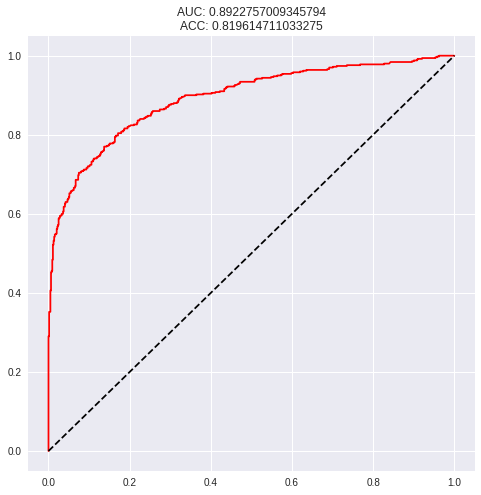

In [24]:
plot_metrics(preds, y_test);

In [25]:
pred_analysis_df = pd.DataFrame({'tweet':X_test.values, 'pred':preds.flatten(), 'real':y_test})
pred_analysis_df['rounded'] = np.array(pred_analysis_df['pred'] > 0.5, dtype='int')
diff = pred_analysis_df[pred_analysis_df['real'] != pred_analysis_df['rounded']]

In [26]:
#change to see other examples
idx = 44

tweet, real, pred = diff.iloc[idx, [0,2,3]]
print(tweet)
print("PRED: " + str(pred))
print("REAL: " + str(real))

1970 Mercury Cyclone GT Quarter Panel D/S Rear Trim Moulding Cobra Jet 429CJ www www
PRED: 0
REAL: 1


In [28]:
#Training with removing stopwords
# tweets = X_pred['tweet']

#Traing without removing stopwords
tweets = dataf_test['clean']

inp_tok, ids, segments = get_inputs(tweets, xlnet_tokenizer)
preds = xlnet.predict(inp_tok, verbose=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


102/102 [==============================] - 65s 641ms/step


In [29]:
dataf_test = test
dataf_test['target'] = preds
dataf_test['target'] = np.array(dataf_test['target'] >= 0.5, dtype='int')
dataf_test[['id', 'target']].to_csv('submission.csv', index=False)